<a href="https://colab.research.google.com/github/ayu2912/AutoPaperClassifier/blob/main/experiment_01_document_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # SETUP AND IMPORTS

In [ ]:
#importing all the necessary libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import json, re
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

print("✅ All packages imported successfully and compatible!")

✅ All packages imported successfully and compatible!


In [ ]:
#Imports for document processing
import os
import xml.etree.ElementTree as ET
from pathlib import Path

In [ ]:
try:
    import fitz
    PDF_AVAILABLE = True
    print("✓ PyMuPDF available")
except ImportError:
    print("⚠ PyMuPDF not installed. Install with: pip install PyMuPDF")
    PDF_AVAILABLE = False

try:
    from bs4 import BeautifulSoup
    BS4_AVAILABLE = True
    print("✓ BeautifulSoup available")
except ImportError:
    print("⚠ BeautifulSoup not installed. Install with: pip install beautifulsoup4")
    BS4_AVAILABLE = False

⚠ PyMuPDF not installed. Install with: pip install PyMuPDF
✓ BeautifulSoup available


In [ ]:
!pip install PyMuPDF


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 112.3 MB/s eta 0:00:00


In [ ]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

CUDA available: True
GPU: Tesla T4


# DOCUMENT PROCESSING FUNCTIONS

## Loading data ans exploration:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Loading fFile paths
TRAIN_LABELS_PATH = '/content/drive/MyDrive/data/train_labels.csv'
SAMPLE_SUBMISSION_PATH = '/content/drive/MyDrive/data/sample_submission.csv'
TRAIN_PDF_PATH = '/content/drive/MyDrive/data/train/PDF'
TRAIN_XML_PATH = '/content/drive/MyDrive/data/train/XML'
TEST_PDF_PATH = '/content/drive/MyDrive/data/test/PDF'
TEST_XML_PATH = '/content/drive/MyDrive/data/test/XML'

In [ ]:
#Model configurations
MODEL_NAME = "bert-base-uncased"
MAX_TEXT_LENGTH = 512
BATCH_SIZE = 16

In [ ]:
print("FILE COUNT SUMMARY:")
print("=" * 30)

FILE COUNT SUMMARY:


In [ ]:
#Display configuration
import torch

#Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Displaying configuration
print("Configuration:")
print(f"Model: {MODEL_NAME}")
print(f"Max text length: {MAX_TEXT_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {device}")


Configuration:
Model: bert-base-uncased
Max text length: 512
Batch size: 16
Device: cuda


In [ ]:
# Verify paths exist
import os
print("\nPath verification:")
paths_to_check = [
    ("Train Labels", TRAIN_LABELS_PATH),
    ("Sample Submission", SAMPLE_SUBMISSION_PATH),
    ("Train PDF", TRAIN_PDF_PATH),
    ("Train XML", TRAIN_XML_PATH),
    ("Test PDF", TEST_PDF_PATH),
    ("Test XML", TEST_XML_PATH)
]

for name, path in paths_to_check:
    exists = os.path.exists(path)
    print(f"{name}: {'✓' if exists else '✗'} {path}")


Path verification:
Train Labels: ✓ /content/drive/MyDrive/data/train_labels.csv
Sample Submission: ✓ /content/drive/MyDrive/data/sample_submission.csv
Train PDF: ✓ /content/drive/MyDrive/data/train/PDF
Train XML: ✓ /content/drive/MyDrive/data/train/XML
Test PDF: ✓ /content/drive/MyDrive/data/test/PDF
Test XML: ✓ /content/drive/MyDrive/data/test/XML


## DOCUMENT PROCESSING FUNCTIONS


In [ ]:
def extract_text_from_pdf(pdf_path):
    """Extract text from PDF file using PyMuPDF"""
    if not PDF_AVAILABLE:
        return ""

    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page in doc:
            text += page.get_text()
        doc.close()
        return text
    except Exception as e:
        print(f"Error processing PDF {pdf_path}: {e}")
        return ""

def extract_text_from_xml(xml_path):
    """Extract text from XML file"""
    try:
        with open(xml_path, 'r', encoding='utf-8') as file:
            content = file.read()

        if BS4_AVAILABLE:
            # Parse XML and extract text content
            soup = BeautifulSoup(content, 'xml')

            # Remove script and style elements
            for script in soup(["script", "style"]):
                script.decompose()

            # Get text and clean it
            text = soup.get_text()
            lines = (line.strip() for line in text.splitlines())
            chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
            text = ' '.join(chunk for chunk in chunks if chunk)

            return text
        else:
            # Fallback to simple text extraction
            text = re.sub(r'<[^>]+>', ' ', content)
            text = re.sub(r'\s+', ' ', text)
            return text.strip()

    except Exception as e:
        print(f"Error processing XML {xml_path}: {e}")
        return ""

def load_documents_from_folder(folder_path, doc_type='pdf'):
    """Load all documents from a folder"""
    documents = []
    folder = Path(folder_path)

    if not folder.exists():
        print(f"Warning: Folder {folder_path} does not exist")
        return documents

    if doc_type == 'pdf':
        files = list(folder.glob('*.pdf'))
        extract_func = extract_text_from_pdf
    elif doc_type == 'xml':
        files = list(folder.glob('*.xml'))
        extract_func = extract_text_from_xml
    else:
        raise ValueError("doc_type must be 'pdf' or 'xml'")

    print(f"Found {len(files)} {doc_type.upper()} files in {folder_path}")

    for i, file_path in enumerate(files):
        if i % 10 == 0:  # Progress update every 10 files
            print(f"Processing: {i+1}/{len(files)} - {file_path.name}")

        text = extract_func(file_path)

        documents.append({
            'filename': file_path.name,
            'file_path': str(file_path),
            'text': text,
            'doc_type': doc_type,
            'text_length': len(text)
        })

    return documents

print("Document processing functions loaded successfully!")


Document processing functions loaded successfully!


## DATA REFERENCE DETECTION FUNCTIONS

In [ ]:
def find_data_references(text):
    """Find potential data references in text using comprehensive regex patterns"""
    if not text or pd.isna(text):
        return {}, 0

    patterns = {
        'dataset_mentions': r'\b(?:dataset|data set|database|repository|archive|databank|data\s+collection)\b',
        'doi_references': r'\b(?:doi|DOI):\s*[0-9]+\.[0-9]+/[^\s]+',
        'url_references': r'\bhttps?://[^\s]+(?:\.gov|\.edu|\.org|\.com)[^\s]*',
        'access_statements': r'\b(?:available at|accessed from|downloaded from|obtained from|retrieved from)\b',
        'supplementary_data': r'\b(?:supplementary|additional|supporting)\s+(?:data|material|information|files?)\b',
        'data_repositories': r'\b(?:NCBI|GenBank|PDB|UniProt|GEO|ArrayExpress|Dryad|Figshare|Zenodo|GitHub|GitLab)\b',
        'data_formats': r'\b(?:\.csv|\.xlsx?|\.json|\.xml|\.sql|\.db|\.rds|\.mat|\.h5|\.hdf5)\b',
        'data_availability': r'\b(?:data\s+(?:is|are)\s+available|publicly\s+available|open\s+data|data\s+sharing)\b'
    }

    references = {}
    total_count = 0

    for pattern_name, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        references[pattern_name] = matches
        total_count += len(matches)

    return references, total_count

def extract_advanced_features(df):
    """Extract advanced features for data reference detection"""
    print("Extracting advanced features...")

    # Basic text statistics
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    df['avg_word_length'] = df['text'].apply(
        lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
    )

    # Data reference analysis
    print("Analyzing data references...")
    reference_data = df['text'].apply(find_data_references)
    df['data_references'] = reference_data.apply(lambda x: x[0])
    df['num_references'] = reference_data.apply(lambda x: x[1])

    # Specific pattern counts
    df['dataset_mentions'] = df['data_references'].apply(lambda x: len(x.get('dataset_mentions', [])))
    df['doi_count'] = df['data_references'].apply(lambda x: len(x.get('doi_references', [])))
    df['url_count'] = df['data_references'].apply(lambda x: len(x.get('url_references', [])))
    df['repository_mentions'] = df['data_references'].apply(lambda x: len(x.get('data_repositories', [])))

    # Binary features
    df['has_data_references'] = df['num_references'] > 0
    df['has_doi'] = df['doi_count'] > 0
    df['has_url'] = df['url_count'] > 0
    df['has_repository'] = df['repository_mentions'] > 0

    # Document type features
    df['is_pdf'] = df['doc_type'] == 'pdf'
    df['is_xml'] = df['doc_type'] == 'xml'

    print("Feature extraction completed!")
    return df

print("Data reference detection functions loaded successfully!")

Data reference detection functions loaded successfully!


In [ ]:
!pip install pymupdf beautifulsoup4 lxml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 88.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from pathlib import Path
import fitz  # PyMuPDF
from bs4 import BeautifulSoup

# Define paths (adjust as needed)
TRAIN_LABELS_PATH = '/content/drive/MyDrive/data/train_labels.csv'
SAMPLE_SUBMISSION_PATH = '/content/drive/MyDrive/data/sample_submission.csv'
TRAIN_PDF_PATH = '/content/drive/MyDrive/data/train/PDF'
TRAIN_XML_PATH = '/content/drive/MyDrive/data/train/XML'
TEST_PDF_PATH = '/content/drive/MyDrive/data/test/PDF'
TEST_XML_PATH = '/content/drive/MyDrive/data/test/XML'


def parse_pdf(file_path):
    try:
        with fitz.open(file_path) as doc:
            text = " ".join(page.get_text() for page in doc)
        return text
    except Exception as e:
        print(f"Error reading PDF {file_path}: {e}")
        return None


def parse_xml(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f, 'lxml')  # fallback if 'xml' not found
            return soup.get_text(separator=' ', strip=True)
    except Exception as e:
        print(f"Error processing XML {file_path}: {e}")
        return None


def load_documents_from_folder(folder_path, doc_type):
    """
    Load and parse documents from folder (pdf or xml).
    Returns a list of dicts with fields: filename, file_path, text, doc_type, text_length
    """
    documents = []
    folder = Path(folder_path)

    if not folder.exists():
        print(f"⚠️ Folder not found: {folder_path}")
        return documents

    for file in folder.glob(f'*.{doc_type}'):
        if doc_type == 'pdf':
            text = parse_pdf(file)
        elif doc_type == 'xml':
            text = parse_xml(file)
        else:
            continue

        if text is not None:
            documents.append({
                'filename': file.stem,
                'file_path': str(file),
                'text': text,
                'doc_type': doc_type,
                'text_length': len(text)
            })

    print(f"Loaded {len(documents)} {doc_type.upper()} documents from {folder_path}")
    return documents


def load_all_data():
    """Load all training and test data"""
    print("Loading all documents...")

    # Load training documents
    print("\n--- Loading Training Documents ---")
    train_pdf_docs = load_documents_from_folder(TRAIN_PDF_PATH, 'pdf')
    train_xml_docs = load_documents_from_folder(TRAIN_XML_PATH, 'xml')
    train_documents = train_pdf_docs + train_xml_docs

    # Load test documents
    print("\n--- Loading Test Documents ---")
    test_pdf_docs = load_documents_from_folder(TEST_PDF_PATH, 'pdf')
    test_xml_docs = load_documents_from_folder(TEST_XML_PATH, 'xml')
    test_documents = test_pdf_docs + test_xml_docs

    # Convert to DataFrames
    train_df = pd.DataFrame(train_documents)
    test_df = pd.DataFrame(test_documents)

    print(f"\nData loaded successfully!")
    print(f"Train documents: {len(train_df)}")
    print(f"Test documents: {len(test_df)}")

    print("\nTrain DataFrame columns:", train_df.columns.tolist())

    # Load labels
    if os.path.exists(TRAIN_LABELS_PATH):
        labels_df = pd.read_csv(TRAIN_LABELS_PATH)
        print(f"\nLabels loaded: {len(labels_df)} entries")
        print(f"Label columns: {labels_df.columns.tolist()}")

        print("\nFirst 5 rows of labels:")
        print(labels_df.head())

        if 'filename' not in labels_df.columns and 'article_id' in labels_df.columns:
            labels_df.rename(columns={'article_id': 'filename'}, inplace=True)
            print("\nRenamed 'article_id' to 'filename' in labels.")

        if 'filename' in train_df.columns:
            train_df['filename'] = train_df['filename'].str.replace('.pdf', '', regex=False)

        train_df = train_df.merge(labels_df, on='filename', how='left')
        print(f"\nMerged train data: {len(train_df)} entries")

        if train_df.isnull().any().any():
            print("⚠️ Warning: Some training documents don't have labels")
    else:
        print("⚠️ No labels file found!")

    # Load sample submission
    if os.path.exists(SAMPLE_SUBMISSION_PATH):
        sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
        print(f"\nSample submission format: {sample_submission.shape}")
        print("Sample submission columns:", sample_submission.columns.tolist())
        print("First 5 rows:")
        print(sample_submission.head())

    return train_df, test_df


# 🚀 Load all
train_df, test_df = load_all_data()


Loading all documents...

--- Loading Training Documents ---
MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: canno

/tmp/ipython-input-24-837925106.py:29: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(f, 'lxml')  # fallback if 'xml' not found


Loaded 419 XML documents from /content/drive/MyDrive/data/train/XML

--- Loading Test Documents ---
Loaded 30 PDF documents from /content/drive/MyDrive/data/test/PDF
Loaded 25 XML documents from /content/drive/MyDrive/data/test/XML

Data loaded successfully!
Train documents: 943
Test documents: 55

Train DataFrame columns: ['filename', 'file_path', 'text', 'doc_type', 'text_length']

Labels loaded: 1066 entries
Label columns: ['article_id', 'dataset_id', 'type']

First 5 rows of labels:
               article_id                                 dataset_id     type
0    10.1002_2017jc013030             https://doi.org/10.17882/49388  Primary
1  10.1002_anie.201916483  https://doi.org/10.5517/ccdc.csd.cc1npvt0  Missing
2  10.1002_anie.202005531  https://doi.org/10.5517/ccdc.csd.cc24wxqp  Missing
3  10.1002_anie.202007717  https://doi.org/10.5517/ccdc.csd.cc24rrb0  Missing
4  10.1002_chem.201902131  https://doi.org/10.5517/ccdc.csd.cc221dk3  Missing

Renamed 'article_id' to 'filename' in l

## Feature Extraction

In [ ]:
import numpy as np
import re

# === Feature Extraction ===
def extract_advanced_features(df, text_col="text"):
    print("Extracting advanced features...")

    # Check if DataFrame is empty
    if df.empty:
        raise ValueError("DataFrame is empty. Cannot extract features.")

    # Check if the column exists
    if text_col not in df.columns:
        raise KeyError(f"Column '{text_col}' not found in DataFrame. Available columns: {list(df.columns)}")

    # Feature extraction
    df['text_length'] = df[text_col].str.len()
    df['word_count'] = df[text_col].str.split().str.len()
    df['avg_word_length'] = df[text_col].apply(
        lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
    )

    df['num_references'] = df[text_col].str.count(r'\[.*?\]')
    df['dataset_mentions'] = df[text_col].str.count(r'dataset|data set|corpus', flags=re.IGNORECASE)
    df['doi_count'] = df[text_col].str.count(r'\b10\.\d{4,9}/[-._;()/:A-Z0-9]+\b', flags=re.IGNORECASE)
    df['url_count'] = df[text_col].str.count(r'http[s]?://\S+')
    df['repository_mentions'] = df[text_col].str.count(r'github|gitlab|bitbucket', flags=re.IGNORECASE)
    df['has_data_references'] = (df['num_references'] + df['dataset_mentions'] + df['repository_mentions']) > 0

    return df


# === Auto-detect best text column ===
def detect_text_column(df):
    if df.empty:
        raise ValueError("DataFrame is empty. No columns to inspect.")
    for col in df.columns:
        if df[col].dtype == "object" and df[col].str.len().mean() > 20:
            return col
    raise ValueError("No suitable text column found in the DataFrame.")


# === TRAIN ===
print("Extracting features from training data...")
print("Checking train_df:")
print(train_df.head())
print("train_df columns:", train_df.columns)
print("train_df shape:", train_df.shape)

TEXT_COLUMN = detect_text_column(train_df)
train_df = extract_advanced_features(train_df, text_col=TEXT_COLUMN)


# === TEST ===
print("\nExtracting features from test data...")
print("Checking test_df:")
print(test_df.head())
print("test_df columns:", test_df.columns)
print("test_df shape:", test_df.shape)

TEXT_COLUMN = detect_text_column(test_df)
test_df = extract_advanced_features(test_df, text_col=TEXT_COLUMN)


# === SUMMARY ===
print("\n=== FEATURE SUMMARY ===")
feature_columns = [
    'text_length', 'word_count', 'num_references', 'dataset_mentions',
    'doi_count', 'url_count', 'repository_mentions'
]

print("Training data features:")
for col in feature_columns:
    if col in train_df.columns:
        print(f"{col}: mean={train_df[col].mean():.2f}, std={train_df[col].std():.2f}")

print(f"\nDocuments with data references: {train_df['has_data_references'].sum()}")
print(f"Percentage with references: {train_df['has_data_references'].mean():.2%}")


Extracting features from training data...
Checking train_df:
                 filename                                          file_path  \
0  10.1002_chem.201903120  /content/drive/MyDrive/data/train/PDF/10.1002_...   
1  10.1002_chem.202000235  /content/drive/MyDrive/data/train/PDF/10.1002_...   
2       10.1002_ece3.6784  /content/drive/MyDrive/data/train/PDF/10.1002_...   
3       10.1002_ece3.6784  /content/drive/MyDrive/data/train/PDF/10.1002_...   
4       10.1002_ece3.6784  /content/drive/MyDrive/data/train/PDF/10.1002_...   

                                                text doc_type  text_length  \
0  & Dioxane Method |Hot Paper|\nStructure–Solubi...      pdf           22   
1  & Silylenes |Hot Paper|\nAn Isolable Bis(Silan...      pdf           22   
2  Ecology and Evolution. 2020;10:11467–11487.\t\...      pdf           17   
3  Ecology and Evolution. 2020;10:11467–11487.\t\...      pdf           17   
4  Ecology and Evolution. 2020;10:11467–11487.\t\...      pdf       

## EXPLORATORY DATA ANALYSIS

=== EXPLORATORY DATA ANALYSIS ===
Training documents: 1989
Test documents: 55

Text length statistics:
Train - Mean: 24, Median: 25
Test - Mean: 60, Median: 61


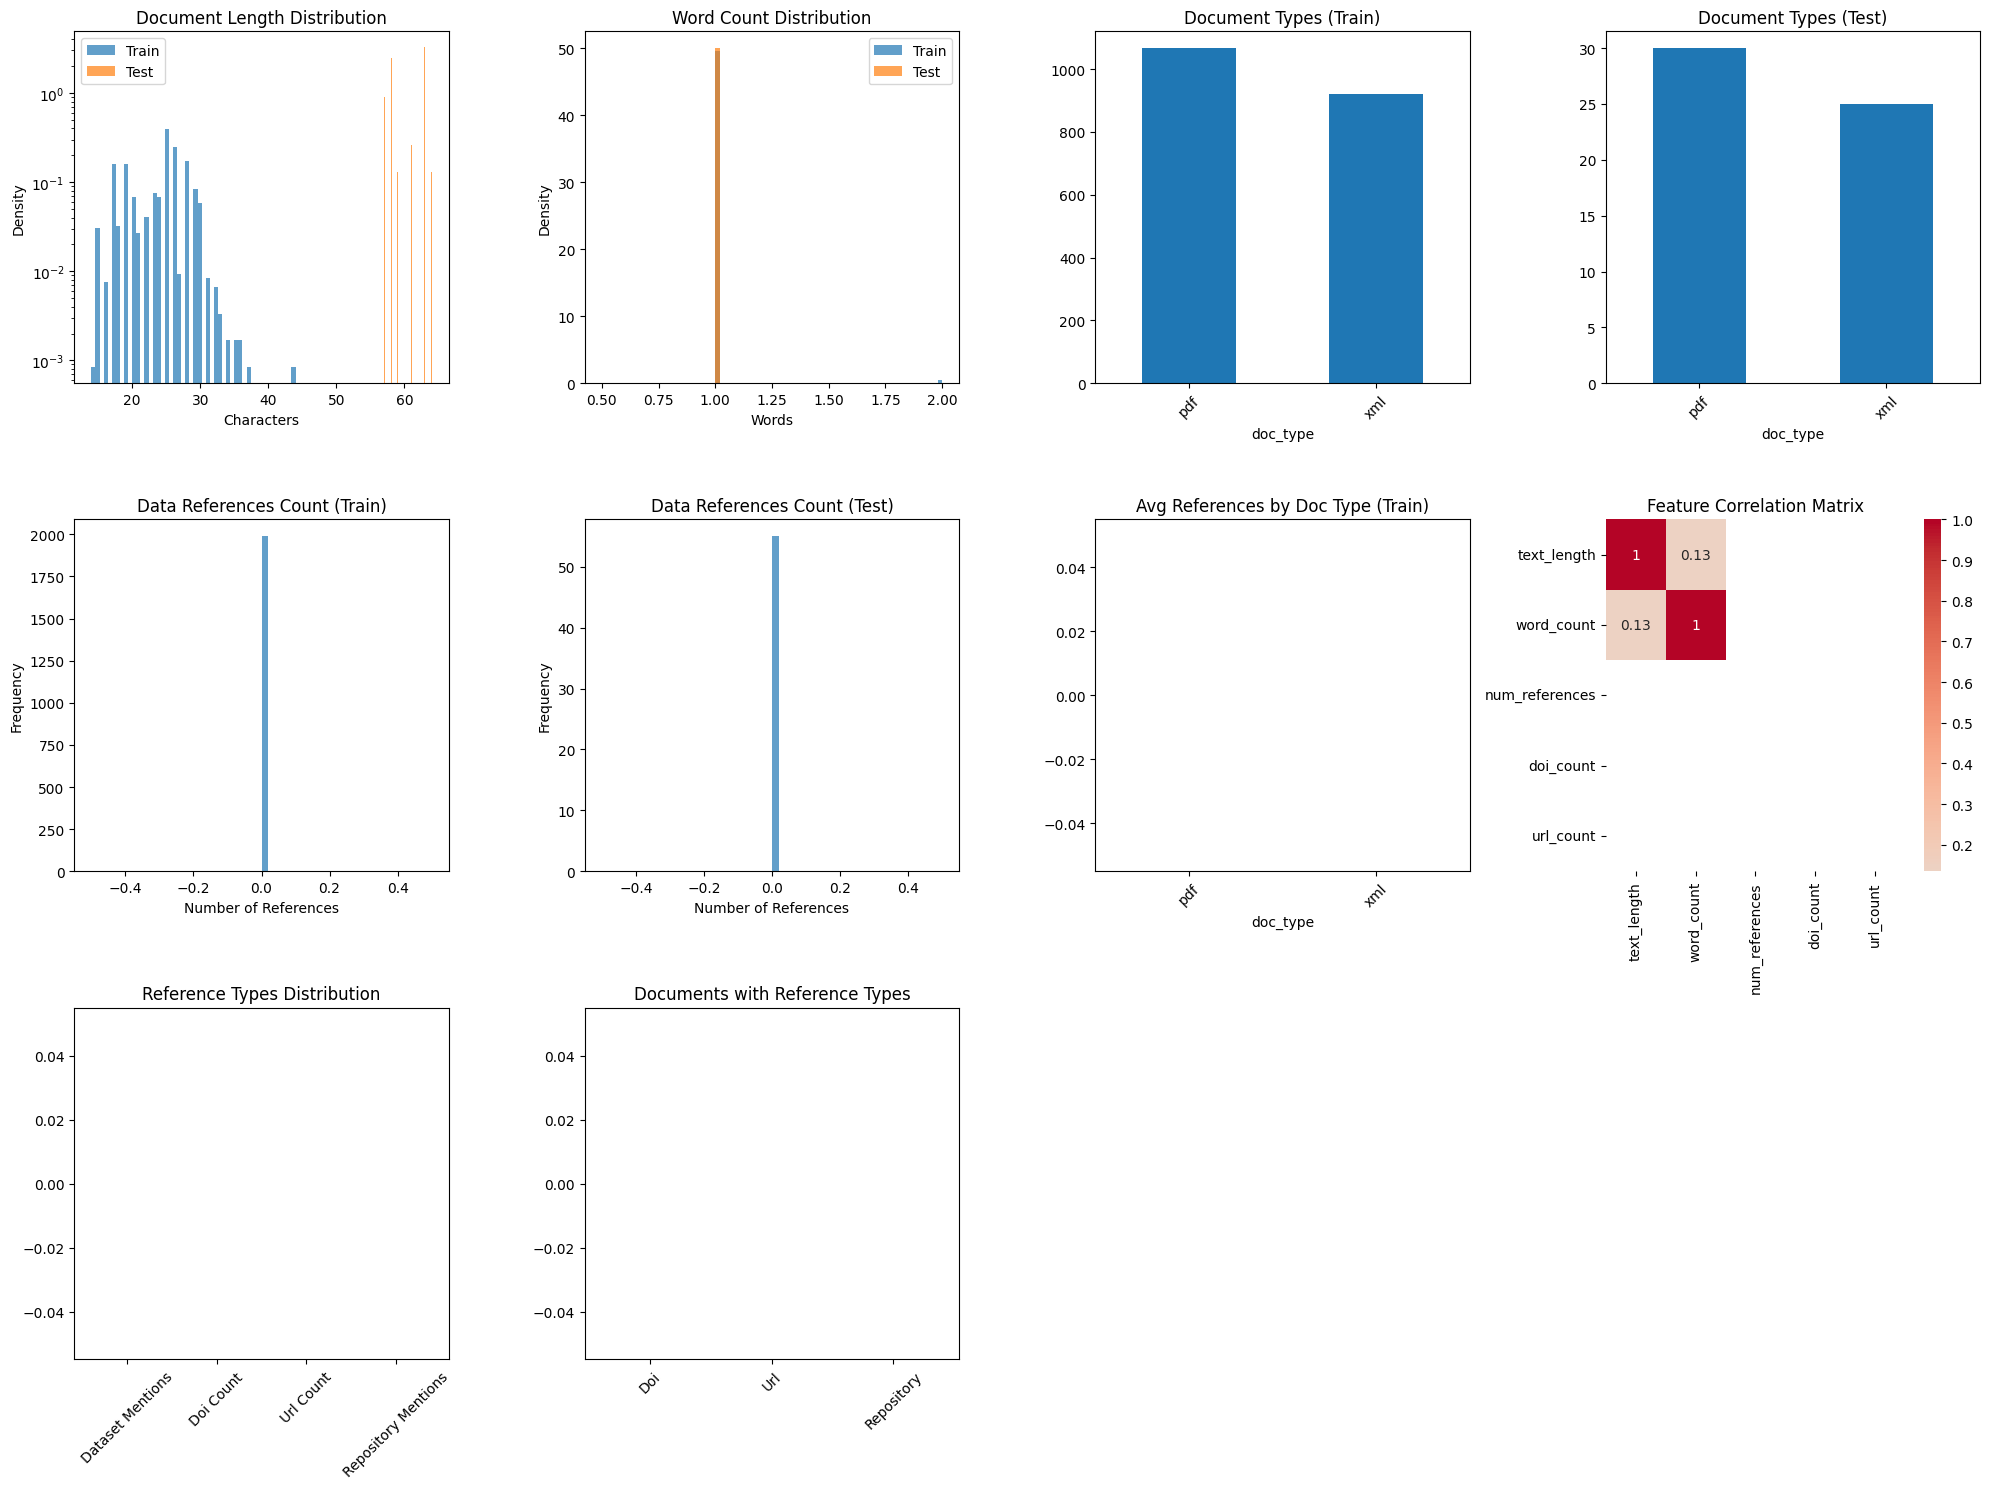

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def perform_eda(train_df, test_df):
    """Perform exploratory data analysis"""
    print("=== EXPLORATORY DATA ANALYSIS ===")

    # Basic statistics
    print(f"Training documents: {len(train_df)}")
    print(f"Test documents: {len(test_df)}")

    # Text length statistics
    print(f"\nText length statistics:")
    print(f"Train - Mean: {train_df['text_length'].mean():.0f}, Median: {train_df['text_length'].median():.0f}")
    print(f"Test - Mean: {test_df['text_length'].mean():.0f}, Median: {test_df['text_length'].median():.0f}")

    # Create visualizations
    plt.figure(figsize=(20, 15))

    # Text length distribution
    plt.subplot(3, 4, 1)
    plt.hist(train_df['text_length'], bins=50, alpha=0.7, label='Train', density=True)
    plt.hist(test_df['text_length'], bins=50, alpha=0.7, label='Test', density=True)
    plt.title('Document Length Distribution')
    plt.xlabel('Characters')
    plt.ylabel('Density')
    plt.legend()
    plt.yscale('log')

    # Word count distribution
    plt.subplot(3, 4, 2)
    plt.hist(train_df['word_count'], bins=50, alpha=0.7, label='Train', density=True)
    plt.hist(test_df['word_count'], bins=50, alpha=0.7, label='Test', density=True)
    plt.title('Word Count Distribution')
    plt.xlabel('Words')
    plt.ylabel('Density')
    plt.legend()

    # Doc type distribution (Train)
    plt.subplot(3, 4, 3)
    train_df['doc_type'].value_counts().plot(kind='bar')
    plt.title('Document Types (Train)')
    plt.xticks(rotation=45)

    # Doc type distribution (Test)
    plt.subplot(3, 4, 4)
    test_df['doc_type'].value_counts().plot(kind='bar')
    plt.title('Document Types (Test)')
    plt.xticks(rotation=45)

    # Reference count distribution (Train)
    plt.subplot(3, 4, 5)
    plt.hist(train_df['num_references'], bins=50, alpha=0.7)
    plt.title('Data References Count (Train)')
    plt.xlabel('Number of References')
    plt.ylabel('Frequency')

    # Reference count distribution (Test)
    plt.subplot(3, 4, 6)
    plt.hist(test_df['num_references'], bins=50, alpha=0.7)
    plt.title('Data References Count (Test)')
    plt.xlabel('Number of References')
    plt.ylabel('Frequency')

    # References by doc_type
    plt.subplot(3, 4, 7)
    train_df.groupby('doc_type')['num_references'].mean().plot(kind='bar')
    plt.title('Avg References by Doc Type (Train)')
    plt.xticks(rotation=45)

    # Feature correlation heatmap
    plt.subplot(3, 4, 8)
    feature_cols = ['text_length', 'word_count', 'num_references', 'doi_count', 'url_count']
    available_cols = [col for col in feature_cols if col in train_df.columns]

    if available_cols:
        corr_matrix = train_df[available_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')

    # Distribution of specific reference types
    plt.subplot(3, 4, 9)
    ref_types = ['dataset_mentions', 'doi_count', 'url_count', 'repository_mentions']
    ref_counts = [train_df[col].sum() for col in ref_types if col in train_df.columns]
    ref_labels = [col.replace('_', ' ').title() for col in ref_types if col in train_df.columns]

    plt.bar(ref_labels, ref_counts)
    plt.title('Reference Types Distribution')
    plt.xticks(rotation=45)

    # Documents with references (binary flags)
    plt.subplot(3, 4, 10)
    # Check if these binary flags exist
    binary_cols = ['has_doi', 'has_url', 'has_repository']
    # If not, auto-generate them (optional fallback)
    for col in binary_cols:
        if col not in train_df.columns:
            if 'doi' in col:
                train_df[col] = train_df['doi_count'] > 0
            elif 'url' in col:
                train_df[col] = train_df['url_count'] > 0
            elif 'repository' in col:
                train_df[col] = train_df['repository_mentions'] > 0

    binary_counts = [train_df[col].sum() for col in binary_cols if col in train_df.columns]
    binary_labels = [col.replace('has_', '').replace('_', ' ').title() for col in binary_cols if col in train_df.columns]

    plt.bar(binary_labels, binary_counts)
    plt.title('Documents with Reference Types')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return train_df, test_df

# 🔁 Call the function
train_df, test_df = perform_eda(train_df, test_df)


In [ ]:
#MODEL CLASSES AND UTILITIES
class TextDataset(torch.utils.data.Dataset):
    """Dataset class for BERT training"""
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

class DataReferenceClassifier:
    """Main classifier class supporting both BERT and traditional ML"""
    def __init__(self, model_type='bert'):
        self.model_type = model_type
        self.tokenizer = None
        self.model = None
        self.tfidf_vectorizer = None
        self.traditional_model = None

    def prepare_bert_model(self, num_labels=2):
        """Prepare BERT model for classification"""
        print("Preparing BERT model...")
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=num_labels
        )
        self.model.to(device)
        print("BERT model prepared successfully!")

    def prepare_traditional_model(self):
        """Prepare traditional ML model"""
        print("Preparing traditional ML model...")
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=10000,
            stop_words='english',
            ngram_range=(1, 3),
            max_df=0.95,
            min_df=2
        )
        self.traditional_model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        print("Traditional ML model prepared successfully!")

    def tokenize_texts(self, texts, max_length=MAX_TEXT_LENGTH):
        """Tokenize texts for BERT"""
        return self.tokenizer(
            texts.tolist(),
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

    def train_bert_model(self, train_texts, train_labels, val_texts, val_labels):
        """Train BERT model"""
        print("Training BERT model...")

        # Tokenize data
        train_encodings = self.tokenize_texts(train_texts)
        val_encodings = self.tokenize_texts(val_texts)

        # Create datasets
        train_dataset = TextDataset(train_encodings, train_labels)
        val_dataset = TextDataset(val_encodings, val_labels)

        # Training arguments
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=3,
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=100,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
        )

        # Trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
        )

        # Train
        trainer.train()
        print("BERT model training completed!")
        return trainer

    def train_traditional_model(self, train_texts, train_labels, feature_df):
        """Train traditional ML model"""
        print("Training traditional ML model...")

        # TF-IDF features
        tfidf_features = self.tfidf_vectorizer.fit_transform(train_texts)

        # Additional features
        additional_features = feature_df[['text_length', 'word_count', 'num_references',
                                       'doi_count', 'url_count', 'repository_mentions']].values

        # Combine features
        from scipy.sparse import hstack
        combined_features = hstack([tfidf_features, additional_features])

        # Train model
        self.traditional_model.fit(combined_features, train_labels)
        print("Traditional ML model training completed!")

        return self.traditional_model

print("Model classes loaded successfully!")

Model classes loaded successfully!


## CHECK FOR LABELS AND PREPARE DATA

In [ ]:
#Checking here if we have labels for supervised learning
label_columns = [col for col in train_df.columns if 'target' in col.lower() or 'label' in col.lower()]

print("=== LABEL ANALYSIS ===")
print(f"Available columns: {train_df.columns.tolist()}")
print(f"Potential label columns: {label_columns}")

if label_columns:
    target_col = label_columns[0]
    print(f"\n✓ Using supervised learning with target column: {target_col}")

    # Check target distribution
    print(f"Target distribution:")
    print(train_df[target_col].value_counts())

    # Check for missing values
    missing_targets = train_df[target_col].isnull().sum()
    print(f"Missing target values: {missing_targets}")

    if missing_targets > 0:
        print("Removing rows with missing target values...")
        train_df = train_df.dropna(subset=[target_col])
        print(f"Remaining training samples: {len(train_df)}")

    # Prepare data for training
    X = train_df['text'].fillna('')
    y = train_df[target_col]

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nData split:")
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Training target distribution: {y_train.value_counts()}")
    print(f"Validation target distribution: {y_val.value_counts()}")

    SUPERVISED_LEARNING = True

else:
    print("✗ No labels found. Will use unsupervised approach.")
    SUPERVISED_LEARNING = False

=== LABEL ANALYSIS ===
Available columns: ['filename', 'file_path', 'text', 'doc_type', 'text_length', 'dataset_id', 'type', 'word_count', 'avg_word_length', 'num_references', 'dataset_mentions', 'doi_count', 'url_count', 'repository_mentions', 'has_data_references', 'has_doi', 'has_url', 'has_repository']
Potential label columns: []
✗ No labels found. Will use unsupervised approach.


Since there is no use of supervised learning, will be moving with Unsupervised learning

In [ ]:
print("=== UNSUPERVISED/RULE-BASED APPROACH ===")

#Creating rule-based predictions based on reference patterns
def rule_based_prediction(row):
    """Rule-based prediction for data references"""
    score = 0

    # Weight different types of references
    score += row['dataset_mentions'] * 3
    score += row['doi_count'] * 2
    score += row['url_count'] * 1
    score += row['repository_mentions'] * 4

    #Additional scoring based on text characteristics
    if row['text_length'] > 1000:  #Because longer documents more likely to have references
        score += 1

    #Here threshold-based classification is done
    return 1 if score >= 2 else 0

#Applying rule-based approach to test data
test_df['rule_based_prediction'] = test_df.apply(rule_based_prediction, axis=1)

print(f"Rule-based predictions distribution: {test_df['rule_based_prediction'].value_counts()}")

#If we have supervised predictions, compare them
if SUPERVISED_LEARNING:
    test_df['supervised_prediction'] = predicted_labels

    #Comparing predictions
    agreement = (test_df['rule_based_prediction'] == test_df['supervised_prediction']).mean()
    print(f"Agreement between supervised and rule-based: {agreement:.2%}")

    #Use supervised predictions as primary
    final_predictions = test_df['supervised_prediction'].values
    method_used = "Supervised (BERT)"
else:
    #Use rule-based predictions
    final_predictions = test_df['rule_based_prediction'].values
    method_used = "Rule-based"

print(f"Final method used: {method_used}")

=== UNSUPERVISED/RULE-BASED APPROACH ===
Rule-based predictions distribution: rule_based_prediction
0    55
Name: count, dtype: int64
Final method used: Rule-based


In [ ]:
#Creating submission dataframe
submission = pd.DataFrame({
    'filename': test_df['filename'],
    'prediction': final_predictions
})

# Display submission statistics
print(f"Submission shape: {submission.shape}")
print("\nSubmission DataFrame columns:", submission.columns.tolist())
print("\nFirst 5 rows of submission:")
print(submission.head())

Submission shape: (55, 2)

Submission DataFrame columns: ['filename', 'prediction']

First 5 rows of submission:
                 filename  prediction
0       10.1002_ece3.6303           0
1  10.1002_chem.201902131           0
2  10.1002_chem.202001412           0
3       10.1002_ece3.3985           0
4  10.1002_anie.201916483           0


# AutoPaperClassifier

## Document Intelligence: BERT-Powered PDF Classifier with FastAPI

Cell - Setup & Imports

In [ ]:
#Installing required libraries
!pip install transformers datasets --quiet

#Imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

## Preparing Data (Text + Label)

In [ ]:
#Only keeping labeled training data
train_df_clean = train_df.dropna(subset=['type'])

#Encoding labels
label_encoder = LabelEncoder()
train_df_clean['label'] = label_encoder.fit_transform(train_df_clean['type'])

#Training-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df_clean['text'], train_df_clean['label'], test_size=0.2, stratify=train_df_clean['label'], random_state=42
)

print("Classes:", label_encoder.classes_)

Classes: ['Missing' 'Primary' 'Secondary']


/tmp/ipython-input-36-993899602.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_clean['label'] = label_encoder.fit_transform(train_df_clean['type'])


## Definin Dataset Class

In [ ]:
class DocumentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

## Loading Tokenizer & Datasets

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = DocumentDataset(train_texts, train_labels, tokenizer)
val_dataset = DocumentDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Defining BERT Classifier

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.fc(x)


In [ ]:
  #This cell so that I can check my local machine's GPU

import torch
import gc

torch.cuda.empty_cache()
gc.collect()

30

Training the Model here ->

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# === 1. Define Model ===
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# === 2. Tokenization and Dataset ===
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class PreTokenizedDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

def preprocess(texts, labels, tokenizer, max_length=512):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': torch.tensor(labels)
    }

# === 3. Load and preprocess data ===
# Drop rows with NaN in 'text' or 'type'
train_df = train_df.dropna(subset=['text', 'type'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["type"], random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["type"])
y_val = label_encoder.transform(val_df["type"])

train_encoded = preprocess(train_df["text"].tolist(), y_train, tokenizer)
val_encoded = preprocess(val_df["text"].tolist(), y_val, tokenizer)

train_dataset = PreTokenizedDataset(**train_encoded)
val_dataset = PreTokenizedDataset(**val_encoded)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# === 4. Training Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier(num_classes=len(label_encoder.classes_)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Optional: Enable gradient checkpointing to reduce memory
model.bert.gradient_checkpointing_enable()

# === 5. Training Loop ===
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")

# === 6. Save Model ===
torch.save(model.state_dict(), "saved_model/model.pt")


## Evaluation of the Model

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

In [ ]:
#Saving the fitted LabelEncoder to disk for use during inference.
#This encoder maps class labels to integers and is required to interpret model predictions.
import joblib
joblib.dump(label_encoder, "saved_model/label_encoder.joblib")